In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y = train["label"].to_numpy()
X = train.drop("label", axis=1).to_numpy()

X_test = test.to_numpy()

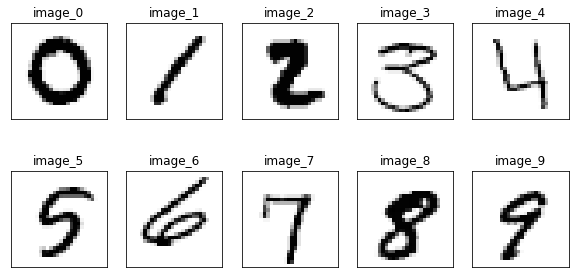

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    mask = y == i
    image = X[mask][0].reshape((28, 28))
    
    axs[i//5, i%5].set_title(f'image_{i}')
    axs[i//5, i%5].imshow(image, cmap='Greys')
    axs[i//5, i%5].set_xticks([])
    axs[i//5, i%5].set_yticks([])

In [7]:
print(X.shape, y.shape)

(42000, 784) (42000,)


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y)

In [9]:
preproc = lambda x: (x-127.5)/127.5

train = tf.data.Dataset.from_tensor_slices(((preproc(X_train), (y_train))))
valid = tf.data.Dataset.from_tensor_slices(((preproc(X_valid), (y_valid))))

test = tf.data.Dataset.from_tensor_slices((preproc(X_test)))

2023-01-02 11:13:51.495731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:13:51.496670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:13:51.839080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:13:51.839978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:13:51.840804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [10]:
train_cached = train.shuffle(X_train.shape[0]).batch(256).cache().prefetch(tf.data.AUTOTUNE)
valid_cached = valid.batch(256).cache().prefetch(tf.data.AUTOTUNE)

In [11]:
def plot_accuracy_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    ax = plt.gca()
    ax.set_ylim([0.85, 1])
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    ax = plt.gca()
    ax.set_ylim([0, 0.5])
    plt.show()

In [12]:
def get_mistakes(y_true, y_pred):
    size = len(y_true)
    mask = y_true != y_pred
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    matrix = np.zeros((10, 10))
    for i in range(len(y_true)):
        matrix[y_true[i], y_pred[i]] += 1
    return matrix

In [13]:
def try_model(model, train_cached, valid_cached, train, valid, epochs=40):
    print(f'This model has {model.count_params()} parameters')
    
    history = model.fit(train_cached,
                        validation_data=valid_cached,
                        verbose=0,
                        epochs=epochs)
    plot_accuracy_loss(history)
    
    y_train_pred = np.argmax(model.predict(train.map(lambda x,y: x).batch(256)), axis=-1)
    y_valid_pred = np.argmax(model.predict(valid.map(lambda x,y: x).batch(256)), axis=-1)
    
    ax = plt.axes()
    heatmap = sns.heatmap(get_mistakes(y_train, y_train_pred), linewidths=0.5, vmax=60, ax=ax)
    ax.set_title('training mistakes')
    heatmap.set(xlabel='predicted digit', ylabel='true digit')
    plt.show()
    
    ax = plt.axes()
    heatmap = sns.heatmap(get_mistakes(y_valid, y_valid_pred), linewidths=0.5, vmax=25, ax=ax)
    heatmap.set(xlabel='predicted digit', ylabel='true digit')
    ax.set_title('validation mistakes')
    plt.show()

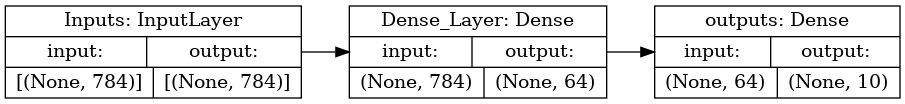

In [14]:
model = Sequential([
    layers.Input((784,), name="Inputs"),
    layers.Dense(64, activation="relu", name="Dense_Layer"),
    layers.Dense(10, activation="softmax", name="outputs")
])

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
param_count = model.count_params()
plot_model(model, show_layer_names=True, expand_nested=True, show_shapes=True, rankdir="LR")

This model has 50890 parameters


2023-01-02 11:14:00.419226: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


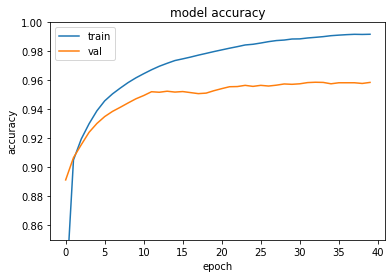

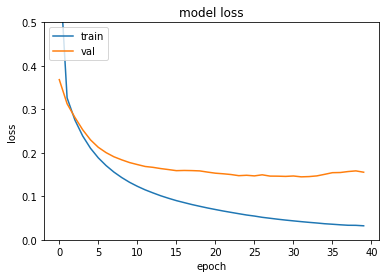

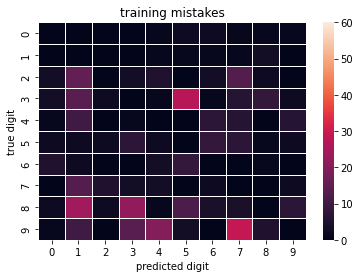

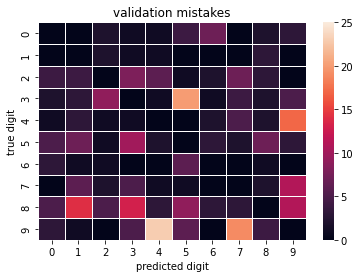

In [15]:
try_model(model, train_cached, valid_cached, train, valid)

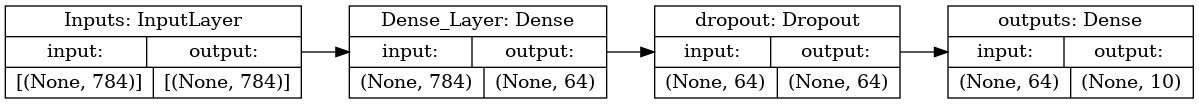

In [16]:
model = Sequential([
    layers.Input((784,), name="Inputs"),
    layers.Dense(64, activation="relu", name="Dense_Layer"),
    layers.Dropout(0.2, name="dropout"),
    layers.Dense(10, activation="softmax", name="outputs")
])

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
plot_model(model, show_layer_names=True, expand_nested=True, show_shapes=True, rankdir="LR")

This model has 50890 parameters


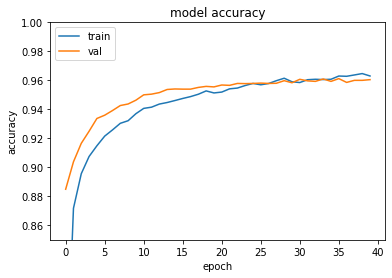

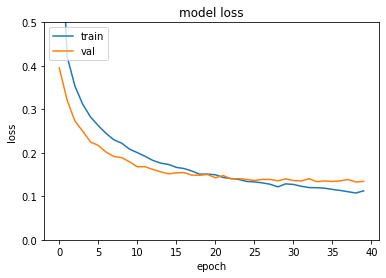

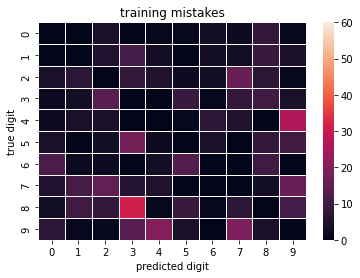

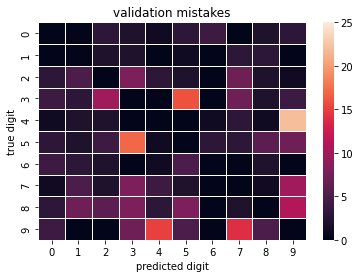

In [17]:
try_model(model, train_cached, valid_cached, train, valid)

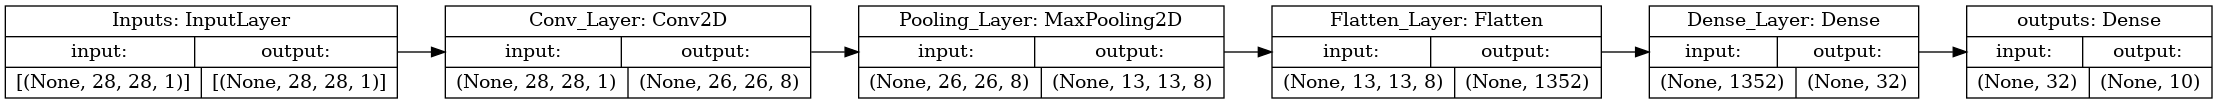

In [18]:
model = Sequential([
    layers.Input((28,28,1), name="Inputs"),
    layers.Conv2D(8,3, activation="relu", name="Conv_Layer"),
    layers.MaxPooling2D(2, name="Pooling_Layer"),
    layers.Flatten(name="Flatten_Layer"),
    layers.Dense(32, activation="relu", name="Dense_Layer"),
    layers.Dense(10, activation="softmax", name="outputs")
])

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
param_count = model.count_params()
plot_model(model, show_layer_names=True, expand_nested=True, show_shapes=True, rankdir="LR")

In [19]:
train_images = train.map(lambda x,y: (tf.reshape(x, (28,28,1)), y))
valid_images = valid.map(lambda x,y: (tf.reshape(x, (28,28,1)), y))

In [20]:
train_images_cached = train_images.shuffle(X_train.shape[0]).batch(256).cache().prefetch(tf.data.AUTOTUNE)
valid_images_cached = valid_images.batch(256).cache().prefetch(tf.data.AUTOTUNE)

This model has 43706 parameters


2023-01-02 11:15:05.489012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


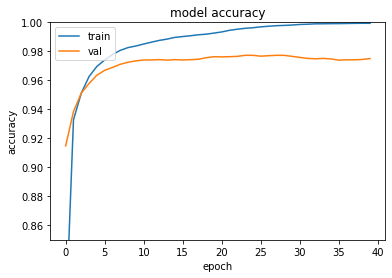

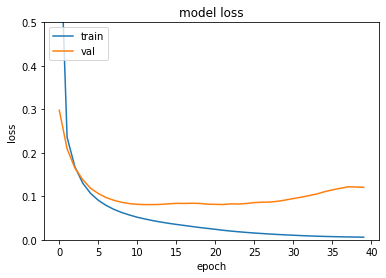

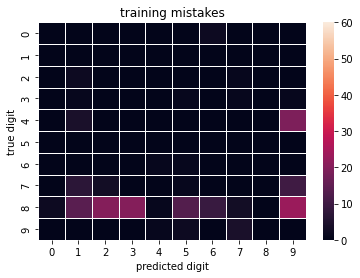

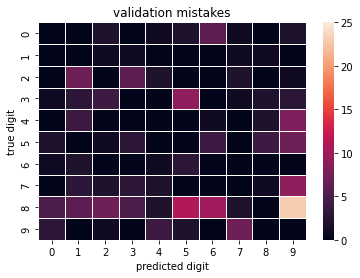

In [21]:
try_model(model, train_images_cached, valid_images_cached, train_images, valid_images)

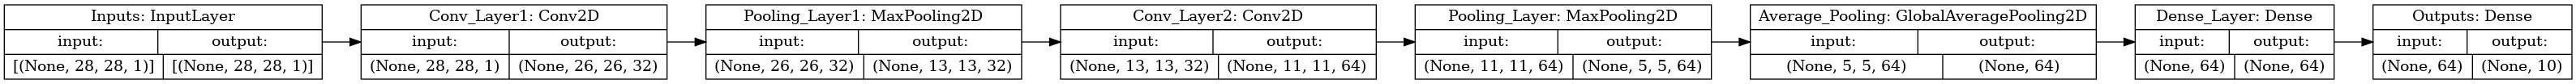

In [22]:
model = Sequential([
    layers.Input((28,28,1), name="Inputs"),
    layers.Conv2D(32, 3, activation="relu", name="Conv_Layer1"),
    layers.MaxPooling2D(2, name="Pooling_Layer1"),
    layers.Conv2D(64, 3, activation="relu", name="Conv_Layer2"),
    layers.MaxPooling2D(2, name="Pooling_Layer"),
    layers.GlobalAveragePooling2D(name="Average_Pooling"),
    layers.Dense(64, activation="relu", name="Dense_Layer"),
    layers.Dense(10, activation="softmax", name="Outputs")
])

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
param_count = model.count_params()
plot_model(model, show_layer_names=True, expand_nested=True, show_shapes=True, rankdir="LR")

This model has 23626 parameters


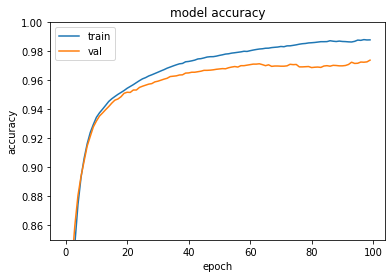

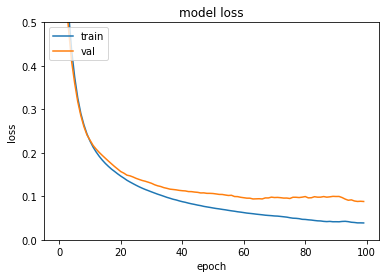

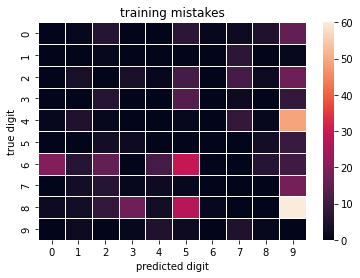

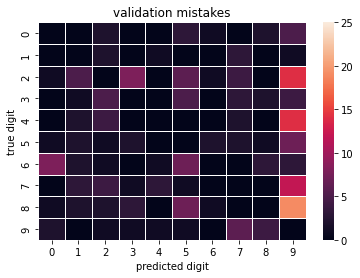

In [23]:
try_model(model, train_images_cached, valid_images_cached, train_images, valid_images, epochs=100)

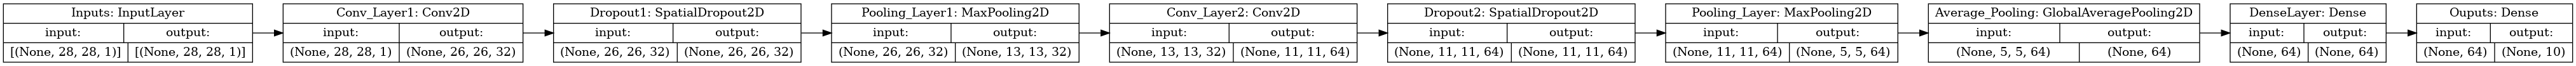

In [24]:
model = Sequential([
    layers.Input((28,28,1), name="Inputs"),
    layers.Conv2D(32, 3, activation="relu", name="Conv_Layer1"),
    layers.SpatialDropout2D(0.1, name="Dropout1"),
    layers.MaxPooling2D(2, name="Pooling_Layer1"),
    layers.Conv2D(64, 3, activation="relu", name="Conv_Layer2"),
    layers.SpatialDropout2D(0.1, name="Dropout2"),
    layers.MaxPooling2D(2, name="Pooling_Layer"),
    layers.GlobalAveragePooling2D(name="Average_Pooling"),
    layers.Dense(64, activation="relu", name="DenseLayer"),
    layers.Dense(10, activation="softmax", name="Ouputs")
])

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
plot_model(model, show_layer_names=True, expand_nested=True, show_shapes=True, rankdir="LR")

This model has 23626 parameters


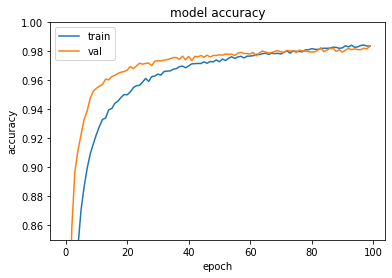

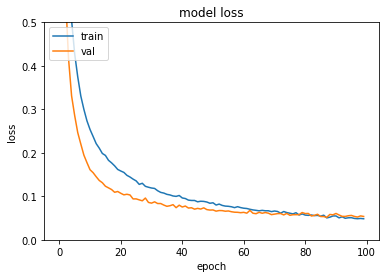

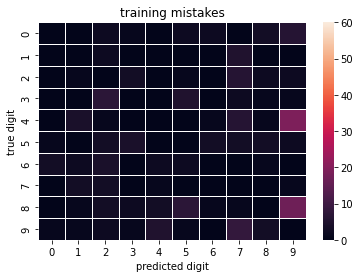

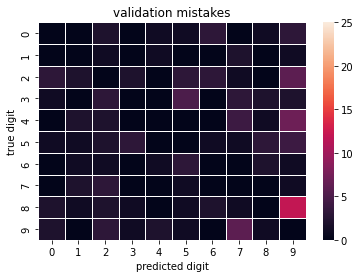

In [25]:
try_model(model, train_images_cached, valid_images_cached, train_images, valid_images, epochs=100)

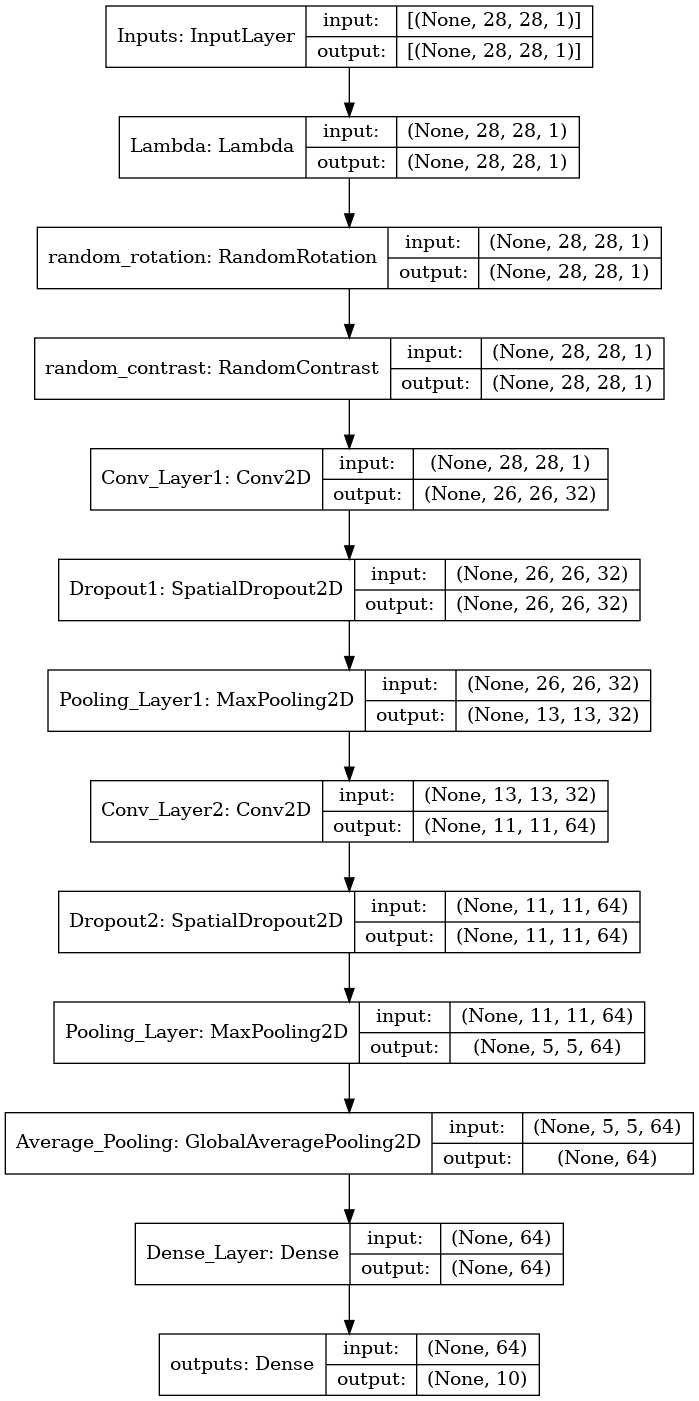

In [26]:
model = Sequential([
    layers.Input((28,28,1), name="Inputs"),
    layers.Lambda(lambda x: (x+1)/2, name="Lambda"),
    layers.RandomRotation(factor=0.1),
    layers.RandomContrast(factor=0.1),
    layers.Conv2D(32, 3, activation="relu", name="Conv_Layer1"),
    layers.SpatialDropout2D(0.05, name="Dropout1"),
    layers.MaxPooling2D(2, name="Pooling_Layer1"),
    layers.Conv2D(64, 3, activation="relu", name="Conv_Layer2"),
    layers.SpatialDropout2D(0.05, name="Dropout2"),
    layers.MaxPooling2D(2, name="Pooling_Layer"),
    layers.GlobalAveragePooling2D(name="Average_Pooling"),
    layers.Dense(64, activation="relu", name="Dense_Layer"),
    layers.Dense(10, activation="softmax", name="outputs")
])

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
plot_model(model, show_layer_names=True, expand_nested=True, show_shapes=True, rankdir="TB")

This model has 23626 parameters


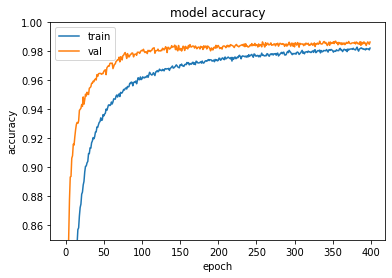

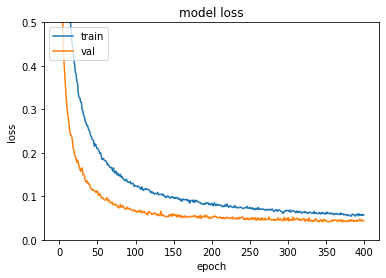

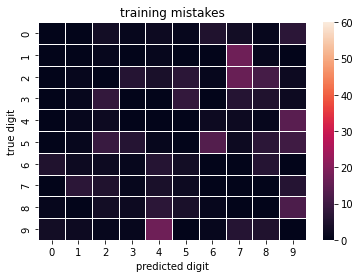

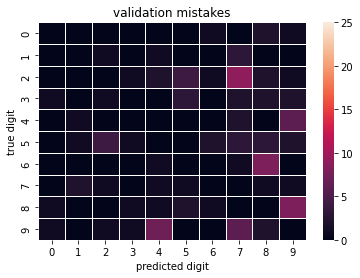

In [27]:
try_model(model, train_images_cached, valid_images_cached, train_images, valid_images, epochs=400)

In [28]:
test_images = test.map(lambda x:(tf.reshape(x, (28,28,1))))

In [29]:
y_test = model.predict(test_images.batch(1024))

In [30]:
predictions = np.argmax(y_test, axis=-1)

In [31]:
submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission["Label"] = predictions
submission.to_csv("submission.csv", index=None)